# Competitive Auctions on eBay.com. 

The file _eBayAuctions.csv_ contains information on 1972 auctions transacted on eBay.com during May–June 2004. The goal is to
use these data to build a model that will distinguish competitive auctions from noncompetitive ones. A competitive auction is defined as an auction with at least two bids placed on the item being auctioned. The data include variables that describe the
item (auction category), the seller (his or her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day of week of auction close). In addition, we have the price at which the auction closed. The goal is to predict whether or not an auction of interest will be competitive.



In [6]:
# Import required packages for this chapter
import math

# Data Analysis
import numpy as np
import pandas as pd

#Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score

import matplotlib.pylab as plt

from dmba import classificationSummary
from dmba import AIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection

%matplotlib inline
#warnings
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'numpy'

__Data preprocessing.__ Create dummy variables for the categorical predictors. These include Category (18 categories), Currency (USD, GBP, Euro), EndDay (Monday–Sunday), and Duration (1, 3, 5, 7, or 10 days).

__a.__ Create pivot tables for the mean of the binary outcome (Competitive?) as a function of the various categorical variables (use the original variables, not the dummies). Use the information in the tables to reduce the number of dummies that will be used in the model. For example, categories that appear most similar with respect to the distribution of competitive auctions could be combined.

__Answer:__

In [1]:
# load the data
ebay_df = pd.read_csv('eBayAuctions.csv')
ebay_df.columns

NameError: name 'pd' is not defined

In [27]:
# prettify variable names
ebay_df.columns = [c.replace('?', '') for c in ebay_df.columns]
ebay_df.columns

Index(['Category', 'currency', 'sellerRating', 'Duration', 'endDay',
       'ClosePrice', 'OpenPrice', 'Competitive'],
      dtype='object')

In [28]:
# check the variable types
ebay_df.dtypes

Category         object
currency         object
sellerRating      int64
Duration          int64
endDay           object
ClosePrice      float64
OpenPrice       float64
Competitive       int64
dtype: object

In [29]:
# pivot table of Competitive and Category
pivot1 = pd.pivot_table(ebay_df, index= 'Category', values= "Competitive",
               aggfunc= [np.mean])
pivot1

,mean
,Competitive
Category,
Antique/Art/Craft,0.564972
Automotive,0.353933
Books,0.500000
Business/Industrial,0.666667
Clothing/Accessories,0.504202
Coins/Stamps,0.297297
Collectibles,0.577406
Computer,0.666667


In [30]:
# pivot table of Competitive and 
pivot2 = pd.pivot_table(ebay_df, index= 'currency', values= "Competitive",
               aggfunc= [np.mean])
pivot2

,mean
,Competitive
currency,
EUR,0.551595
GBP,0.687075
US,0.519350


In [31]:
# pivot table of Competitive and Category
pivot3 = pd.pivot_table(ebay_df, index= 'endDay', values= "Competitive",
               aggfunc= [np.mean])
pivot3

,mean
,Competitive
endDay,
Fri,0.466899
Mon,0.673358
Sat,0.427350
Sun,0.485207
Thu,0.603960
Tue,0.532164
Wed,0.480000


The categories "Business/Industrials" and "Computers" have same average of the binary variable "Competitive." This means that the percentage of competitive auctions in each of these two categories is equal. Hence we can combine the two categories into a single category called "Computers." Similarly, the average of "competitive" for the categories "Antique/Art/Craft" and "Collectibles" are almost same. Therefore, we can combine them into a single category called "collectibles". The auction ending days "Sunday" and "Friday" have approximately equal averages for "competitive". So we can combine them into a single category called "Sun_Fri".

In [32]:
ebay_df.loc[ebay_df.endDay == 'Sun', 'endDay'] = 'Sun_Fri'
ebay_df.loc[ebay_df.endDay == 'Fri', 'endDay'] = 'Sun_Fri'

ebay_df.loc[ebay_df.Category == "Business/Industrial", 'Category'] = 'Computer'
ebay_df.loc[ebay_df.Category == "Antique/Art/Craft", 'Category'] = 'Collectibles'

In [33]:
# pivot table of Competitive and Category
pivot1 = pd.pivot_table(ebay_df, index= 'Category', values= "Competitive",
               aggfunc= [np.mean])
pivot1

,mean
,Competitive
Category,
Automotive,0.353933
Books,0.500000
Clothing/Accessories,0.504202
Coins/Stamps,0.297297
Collectibles,0.572115
Computer,0.666667
Electronics,0.800000
EverythingElse,0.235294


In [34]:
# pivot table of Competitive and Category
pivot3 = pd.pivot_table(ebay_df, index= 'endDay', values= "Competitive",
               aggfunc= [np.mean])
pivot3

,mean
,Competitive
endDay,
Mon,0.673358
Sat,0.427350
Sun_Fri,0.476800
Thu,0.603960
Tue,0.532164
Wed,0.480000


__10.4.b.__ Split the data into training (60%) and validation (40%) datasets. Run a logistic model with all predictors with a cutoff of 0.5.

__Answer:__

Split the data into training (60%) and validation (40%) datasets. Use the random seed 202.

In [35]:
# change variable types to appropriate ones
ebay_df['Category'] = ebay_df['Category'].astype('category')
ebay_df['currency'] = ebay_df['currency'].astype('category')
ebay_df['endDay'] = ebay_df['endDay'].astype('category')

# convert categorical variables into indicator and drop the first column of each of them
ebay_df = pd.get_dummies(ebay_df, prefix_sep='_')
ebay_df.drop(columns=['Category_Automotive', 'currency_EUR', 'endDay_Mon'], inplace=True)


In [36]:
# predictor and response variables
ebay_df['Competitive'] = ebay_df['Competitive'].astype('category')
outcome = 'Competitive'
predictors = list(ebay_df.columns)
predictors.remove(outcome)
y = ebay_df[outcome]
X = ebay_df[predictors]

In [37]:
# split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=202)

In [38]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
classes = list(y.cat.categories)
logit_reg.fit(X_train, y_train)

LogisticRegression(C=1e+42, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# print coefficients
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())

intercept  -0.16233820301376703
       sellerRating  Duration  ClosePrice  OpenPrice  Category_Books  \
coeff     -0.000037 -0.009712    0.084273  -0.098255       -0.030295   

       Category_Clothing/Accessories  Category_Coins/Stamps  \
coeff                      -0.525984              -0.962637   

       Category_Collectibles  Category_Computer  Category_Electronics  ...  \
coeff                0.43238           0.501414              1.162978  ...   

       Category_Pottery/Glass  Category_SportingGoods  Category_Toys/Hobbies  \
coeff                -0.17042                0.485073               0.706662   

       currency_GBP  currency_US  endDay_Sat  endDay_Sun_Fri  endDay_Thu  \
coeff      1.174816     0.305728    -1.05426       -0.711331   -0.724128   

       endDay_Tue  endDay_Wed  
coeff   -0.724097   -0.838984  

[1 rows x 26 columns]


In [40]:
# confusion matrix
# predicted y for validation set
val_pred = logit_reg.predict(X_valid)
# Confusion matrix
classificationSummary(y_valid, val_pred, class_names=classes)

Confusion Matrix (Accuracy 0.7592)

       Prediction
Actual   0   1
     0 289  74
     1 116 310


__10.4.c.__ If we want to predict at the start of an auction whether it will be competitive, we cannot use the information on the closing price. Run a logistic model with all predictors as above, excluding price. How does this model compare to the full
model with respect to predictive accuracy?

__Answer:__

In [41]:
# drop the predictor 'ClosePrice'
X_train = X_train.drop(columns=['ClosePrice'])
X_valid = X_valid.drop(columns=['ClosePrice'])

In [42]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(X_train, y_train)

LogisticRegression(C=1e+42, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
# print coefficients
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X_train.columns).transpose())

intercept  1.239216727766818
       sellerRating  Duration  OpenPrice  Category_Books  \
coeff      -0.00004 -0.080785  -0.007146       -0.220607   

       Category_Clothing/Accessories  Category_Coins/Stamps  \
coeff                       0.285479              -0.815631   

       Category_Collectibles  Category_Computer  Category_Electronics  \
coeff               0.442175            0.98236              1.540873   

       Category_EverythingElse  ...  Category_Pottery/Glass  \
coeff                -1.887026  ...               -0.332043   

       Category_SportingGoods  Category_Toys/Hobbies  currency_GBP  \
coeff                1.358508               0.648472      0.958213   

       currency_US  endDay_Sat  endDay_Sun_Fri  endDay_Thu  endDay_Tue  \
coeff    -0.095301   -1.239433       -0.954428   -1.012888   -0.740699   

       endDay_Wed  
coeff    -0.91522  

[1 rows x 25 columns]


In [44]:
# confusion matrix
# predicted y for validation set
val_pred = logit_reg.predict(X_valid)
# Confusion matrix
classificationSummary(y_valid, val_pred, class_names=classes)

# Keep track of results
accuracies = {}
accuracies['full model'] = [accuracy_score(y_train, logit_reg.predict(X_train)), accuracy_score(y_valid, val_pred)]

Confusion Matrix (Accuracy 0.6312)

       Prediction
Actual   0   1
     0 213 150
     1 141 285


# (32)??
The overall error rate for the full model (1-0.7605 = 23.95%) is much lower than that for the model excluding "close price" (36.63%). Hence the model excluding "close price" has ?? predictive accuracy compared to the full model.

__10.4.d.__ Interpret the meaning of the coefficient for closing price. Does closing price have a practical significance? Is it statistically significant for predicting competitiveness of auctions? (Use a 10% significance level.)

__Answer:__ 

The coefficient for "close price" is 0.084431. This positive coefficient means that higher closing prices are associated with a higher probability of the auction being competitive.

In [45]:
# odds coefficient for close price
math.exp(0.084431)

1.088097762896088

Looking at the odds coefficient (1.1), we see that every $1 increase in the closing price increases the odds of the auction being competitive by a factor of 1.1. We will not use ClosePrice in the remaining questions since closing price won't be available at the time making predictions.

__10.4.e.__ Use stepwise regression as described in chapter 6.4 to find the model with the best fit to the training data (highest accuracy). Which predictors are used?

In [46]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    
    model.fit(X_train[list(variables)], y_train)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return 0
    y_pred = model.predict(X_train[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -accuracy_score(y_train, y_pred)

allVariables = X_train.columns
best_fitting, var_fitting = stepwise_selection(allVariables, train_model, 
                                score_model, verbose=True)
print(sorted(var_fitting))


# Confusion matrix
y_pred = best_fitting.predict(X_valid[list(var_fitting)])
classificationSummary(y_valid, y_pred, class_names=classes)

accuracies['best fitting'] = [accuracy_score(y_train, best_fitting.predict(X_train[list(var_fitting)])), 
                              accuracy_score(y_valid, y_pred)]

Variables: sellerRating, Duration, OpenPrice, Category_Books, Category_Clothing/Accessories, Category_Coins/Stamps, Category_Collectibles, Category_Computer, Category_Electronics, Category_EverythingElse, Category_Health/Beauty, Category_Home/Garden, Category_Jewelry, Category_Music/Movie/Game, Category_Photography, Category_Pottery/Glass, Category_SportingGoods, Category_Toys/Hobbies, currency_GBP, currency_US, endDay_Sat, endDay_Sun_Fri, endDay_Thu, endDay_Tue, endDay_Wed
Start: score=0.00, constant
Step: score=-0.57, add endDay_Sat
Step: score=-0.60, add endDay_Sun_Fri
Step: score=-0.61, add Category_Electronics
Step: score=-0.62, add Category_Toys/Hobbies
Step: score=-0.63, add Category_Jewelry
Step: score=-0.63, add Category_Computer
Step: score=-0.64, add Category_Health/Beauty
Step: score=-0.67, add OpenPrice
Step: score=-0.67, add endDay_Tue
Step: score=-0.67, add sellerRating
Step: score=-0.67, unchanged None
['Category_Computer', 'Category_Electronics', 'Category_Health/Beaut

__10.4.f.__ Use stepwise regression to find the model with the highest accuracy on the validation data. Which predictors are used?

__Answer:__

In [47]:
def score_model(model, variables):
    if len(variables) == 0:
        return 0
    y_pred = model.predict(X_valid[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -accuracy_score(y_valid, y_pred)

allVariables = X_train.columns
best_predictive, var_predictive = stepwise_selection(allVariables, train_model, 
                                score_model, verbose=True)
print(sorted(var_predictive))

# Confusion matrix
y_pred = best_predictive.predict(X_valid[list(var_predictive)])
classificationSummary(y_valid, y_pred, class_names=classes)

accuracies['best predictive'] = [accuracy_score(y_train, best_predictive.predict(X_train[list(var_predictive)])), 
                                 accuracy_score(y_valid, y_pred)]

Variables: sellerRating, Duration, OpenPrice, Category_Books, Category_Clothing/Accessories, Category_Coins/Stamps, Category_Collectibles, Category_Computer, Category_Electronics, Category_EverythingElse, Category_Health/Beauty, Category_Home/Garden, Category_Jewelry, Category_Music/Movie/Game, Category_Photography, Category_Pottery/Glass, Category_SportingGoods, Category_Toys/Hobbies, currency_GBP, currency_US, endDay_Sat, endDay_Sun_Fri, endDay_Thu, endDay_Tue, endDay_Wed
Start: score=0.00, constant
Step: score=-0.57, add OpenPrice
Step: score=-0.58, add Category_Music/Movie/Game
Step: score=-0.60, add Category_SportingGoods
Step: score=-0.63, add Category_Electronics
Step: score=-0.64, add sellerRating
Step: score=-0.65, add Category_EverythingElse
Step: score=-0.65, unchanged None
['Category_Electronics', 'Category_EverythingElse', 'Category_Music/Movie/Game', 'Category_SportingGoods', 'OpenPrice', 'sellerRating']
Confusion Matrix (Accuracy 0.6489)

       Prediction
Actual   0   1

__10.4.g.__ What is the danger of using the best predictive model that you found?

__Answer:__ 

In [48]:
pd.DataFrame(accuracies, index=['training', 'validation']).transpose()

,training,validation
full model,0.655959,0.631179
best fitting,0.672866,0.627376
best predictive,0.641589,0.648923


# (33)&(34)??
The model that was optimized for performance on the training set (best-fitting) has the ?? accuracy. However, it also has the ?? accuracy on the validation set. One way to evaluate the degree of overfitting is to compare the error rates of the training and validation sets. The large difference in training set error and validation error (where training set error is smaller than validation set) indicates that the best-fitting model may be overfit to the training data.

The best-predictive model (optimized for accuracy on the validation set) on the other hand, has a small difference between training and validation accuracy. Here, the accuracy on the validation set is even higher than for the training set. This can be an indication that the model is biased towards the validation set.

To avoid bias towards training or validation set, it is best to use cross validation. 

__10.4.h.__ Explain how and why the best-fitting model and the best predictive models are the same or different.

While finding the best-fitted model means fitting the training data set (using
measures like accuracy), the best predictive model is one that has highest 
prediction accuracy with the validation data.

__10.4.i.__ Use regularized logistic regression with L1 penalty on the training data. Compare its selected predictors and classification performance to the best-fitting and best predictive models.

In [49]:
logit_reg_L1 = LogisticRegressionCV(cv=5, random_state=0, Cs=20, max_iter=500)
logit_reg_L1.fit(X_train, y_train)

# Confusion matrix
classificationSummary(logit_reg_L1.predict(X_valid), val_pred, class_names=classes)


accuracies['regularized'] = [accuracy_score(y_train, logit_reg_L1.predict(X_train)), 
                             accuracy_score(y_valid, logit_reg_L1.predict(X_valid))]

Confusion Matrix (Accuracy 0.8834)

       Prediction
Actual   0   1
     0 289  27
     1  65 408


In [50]:
pd.DataFrame(accuracies, index=['training', 'validation']).transpose()

,training,validation
full model,0.655959,0.631179
best fitting,0.672866,0.627376
best predictive,0.641589,0.648923
regularized,0.657650,0.648923


Regularization leads to a model that has good accuracy on both the training and validation set.

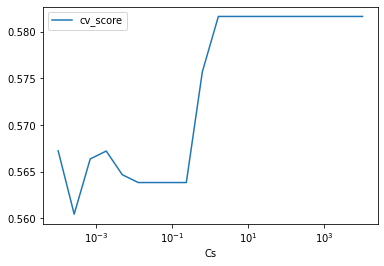

In [51]:
cv_result = pd.DataFrame({
    'Cs': logit_reg_L1.Cs_,
    'cv_score': np.mean(logit_reg_L1.scores_[1], axis=0),
    
})
cv_result.plot.line(x='Cs', y='cv_score', logx=True)

In [52]:
# print coefficients
print('intercept ', logit_reg.intercept_[0])
coefficients = pd.DataFrame({
    'unregularized': logit_reg.coef_[0], 
    'best_fitting': 0,
    'best_predictive': 0,
    'L1 regularized': logit_reg_L1.coef_[0],
    }, index=X_train.columns)
coefficients.loc[var_fitting, 'best_fitting'] = best_fitting.coef_.ravel()
coefficients.loc[var_predictive, 'best_predictive'] = best_predictive.coef_.ravel()
coefficients

intercept  1.239216727766818


,unregularized,best_fitting,best_predictive,L1 regularized
sellerRating,-0.000040,-0.000012,-0.000020,-0.000036
Duration,-0.080785,0.000000,0.000000,-0.085876
OpenPrice,-0.007146,-0.009041,-0.009020,-0.007419
Category_Books,-0.220607,0.000000,0.000000,-0.437808
Category_Clothing/Accessories,0.285479,0.000000,0.000000,-0.038999
Category_Coins/Stamps,-0.815631,0.000000,0.000000,-0.450466
Category_Collectibles,0.442175,0.000000,0.000000,0.442809
Category_Computer,0.982360,0.639226,0.000000,0.567203
Category_Electronics,1.540873,1.128596,1.039034,1.125243
Category_EverythingElse,-1.887026,0.000000,-0.479445,-0.455946


In general, we can see that for cases where both the best_fitting and the best_predictive model exclude a predictor, the coefficient in the regularized model is also closer to zero compared to the unregularized model.

__10.4.j.__ If the major objective is accurate classification, what cutoff value should be used?

,cutoff,accuracy
505,0.505,0.651458
506,0.506,0.655260
507,0.507,0.653992


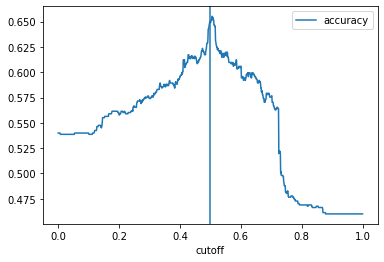

In [53]:
# Determine accuracy for different cutoff values between 0 and 1
data = []
for cutoff in [v / 1000 for v in range(1001)]:
    data.append({'cutoff': cutoff, 
                 'accuracy': accuracy_score(y_valid, logit_reg_L1.predict_proba(X_valid)[:, 1] > cutoff)})
data = pd.DataFrame(data)
ax = data.plot.line(x='cutoff', y='accuracy')
ax.axvline(x=0.5)

data.iloc[data['accuracy'].argmax() - 1:data['accuracy'].argmax() + 2, :]

The highest accuracy is achieved with the default cutoff close to 0.5

__1k.__ Based on these data, what auction settings set by the seller (duration, opening price, ending day, currency) would you recommend as being most likely to lead to a competitive auction?

In [ ]:
# (35)??
# write your answer here